<a href="https://colab.research.google.com/github/narayansathya1698/Product_Detection_On_Shelves/blob/master/On_Shelf_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# New Section

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files

In [ ]:
print(tf.__version__)

1.15.0


In [ ]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names


In [ ]:
xml_coords,classes=xml_to_csv('/content/drive/My Drive/save')
xml_coords.to_csv(f'/content/drive/My Drive/save/coords.csv',index=None)

In [ ]:
#for label_path in ['train_labels', 'test_labels']:
  #image_path = os.path.join(os.getcwd(), label_path)
  #print(image_path)
  #xml_df, classes = xml_to_csv(image_path)
  #xml_df.to_csv(f'{label_path}.csv', index=None)
  #print(f'Successfully converted {label_path} xml to csv.')
xml_train,classes=xml_to_csv('/content/drive/My Drive/object_detection/data/train_labels')
xml_train.to_csv(f'/content/drive/My Drive/object_detection/data/train_labels.csv', index=None)
xml_test,class_names=xml_to_csv('/content/drive/My Drive/object_detection/data/test_labels')
xml_test.to_csv(f'/content/drive/My Drive/object_detection/data/test_labels.csv', index=None)

label_map_path = '/content/drive/My Drive/object_detection/data/label_map.pbtxt'
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

In [ ]:
print(classes)

['Harpic', 'Horlicks', 'Kelllogs', 'Tide']


In [ ]:
%cd /content/drive/My Drive/object_detection

/content/drive/My Drive/object_detection


In [ ]:
!git clone --q https://github.com/tensorflow/models.git

In [ ]:
import sys
sys.path.insert(2,"/content/drive/My Drive/object_detection/models/research,/content/drive/My Drive/object_detection/models/research/slim")

In [ ]:
%cd /content/drive/My Drive/object_detection/models/research

/content/drive/My Drive/object_detection/models/research


In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [ ]:
os.environ['PYTHONPATH'] += ':./:./slim/'

In [ ]:
!python3 object_detection/builders/model_builder_test.py

In [ ]:
from object_detection.utils import dataset_util


#change this to the base directory where your data/ is 
data_base_url = '/content/drive/My Drive/object_detection/data/'


def class_text_to_int(row_label):
  if row_label == 'Harpic':
    return 1
  elif row_label == 'Horlicks':
    return 2
  elif row_label == 'Kelllogs':
    return 3
  elif row_label == 'Tide':
    return 4
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
	with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
	  encoded_jpg = fid.read()
	encoded_jpg_io = io.BytesIO(encoded_jpg)
	image = Image.open(encoded_jpg_io)
	width, height = image.size
	filename = group.filename.encode('utf8')
	image_format = b'jpg'
	xmins = []
	xmaxs = []
	ymins = []
	ymaxs = []
	classes_text = []
	classes = []

	for index, row in group.object.iterrows():
		xmins.append(row['xmin'] / width)
		xmaxs.append(row['xmax'] / width)
		ymins.append(row['ymin'] / height)
		ymaxs.append(row['ymax'] / height)
		classes_text.append(row['class'].encode('utf8'))
		classes.append(class_text_to_int(row['class']))

	tf_example = tf.train.Example(features=tf.train.Features(feature={
		'image/height': dataset_util.int64_feature(height),
		'image/width': dataset_util.int64_feature(width),
		'image/filename': dataset_util.bytes_feature(filename),
		'image/source_id': dataset_util.bytes_feature(filename),
		'image/encoded': dataset_util.bytes_feature(encoded_jpg),
		'image/format': dataset_util.bytes_feature(image_format),
		'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
		'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
		'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
		'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
		'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
		'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
	return tf_example
#creates tfrecord for both csv's
##for csv in ['train_labels', 'test_labels']:
##  writer = tf.io.TFRecordWriter(data_base_url + csv + '.record')

#3	path = data_base_url+location
 ## examples = pd.read_csv(data_base_url + csv + '.csv')
  ##grouped = split(examples, 'filename')
  ##for group in grouped:
    ##tf_example = create_tf_example(group, path)
    ##writer.write(tf_example.SerializeToString())
    
  ##writer.close()
  ##output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')
  ##print('Successfully created the TFRecords: {}'.format(data_base_url +csv + '.record'))###
writer = tf.io.TFRecordWriter(data_base_url + 'train_labels' + '.record')
path='/content/drive/My Drive/object_detection/data/train_images'
examples=pd.read_csv(data_base_url+'train_labels'+'.csv')
grouped=split(examples,'filename')
for group in grouped:
	tf_example = create_tf_example(group, path)
	writer.write(tf_example.SerializeToString())
writer.close()
output_path=os.path.join(os.getcwd(),data_base_url+'train_labels'+'.record')
writer = tf.io.TFRecordWriter(data_base_url + 'test_labels' + '.record')
path='/content/drive/My Drive/object_detection/data/test_images'
examples=pd.read_csv(data_base_url+'test_labels'+'.csv')
grouped=split(examples,'filename')
for group in grouped:
	tf_example = create_tf_example(group, path)
	writer.write(tf_example.SerializeToString())
writer.close()
output_path=os.path.join(os.getcwd(),data_base_url+'test_labels'+'.record')


In [ ]:
%cd /content/drive/My Drive/object_detection/models/research

/content/drive/My Drive/object_detection/models/research


In [ ]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
    },
}

# Select a model from `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'faster_rcnn_inception_v2'

In [ ]:
#the distination folder where the model will be saved
#change this if you have a different working dir
DEST_DIR = '/content/drive/My Drive/object_detection/models/research/pretrained_model'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [ ]:
%cd /content/drive/My Drive/object_detection/training

/content/drive/My Drive/object_detection/training


In [ ]:
%cd /content/drive/My Drive/object_detection/models/research

/content/drive/My Drive/object_detection/models/research


In [ ]:
!ln -s "/content/drive/My Drive" /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': Function not implemented


In [ ]:
%cd /mydrive/object_detection/models/research/object_detection/

/content/drive/My Drive/object_detection/models/research/object_detection


In [ ]:
!python3 /mydrive/object_detection/models/research/object_detection/model_main.py \
    --pipeline_config_path=/mydrive/object_detection/models/research/pretrained_model/pipeline.config \
    --model_dir=/mydrive/object_detection/training

Traceback (most recent call last):
  File "/mydrive/object_detection/models/research/object_detection/model_main.py", line 25, in <module>
    from object_detection import model_hparams
ModuleNotFoundError: No module named 'object_detection'


In [ ]:
!python3 /mydrive/object_detection/models/research/object_detection/export_inference_graph.py \
--input_type image_tensor \
--pipeline_config_path  /mydrive/object_detection/models/research/pretrained_model/pipeline.config \
--trained_checkpoint_prefix /mydrive/object_detection/training/model.ckpt-5349 \
--output_directory /mydrive/object_detection/fine_tuned_model_4/

Traceback (most recent call last):
  File "/mydrive/object_detection/models/research/object_detection/export_inference_graph.py", line 108, in <module>
    from object_detection import exporter
ModuleNotFoundError: No module named 'object_detection'


In [ ]:
%cd /content/drive/My Drive/object_detection/models/research/object_detection

/content/drive/.shortcut-targets-by-id/1XhLoL9aAuyc48shq3OMXroW1zdHvV89p/object_detection/models/research/object_detection


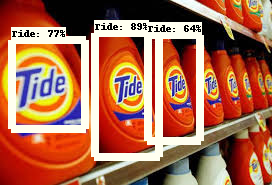

(1, 100, 4)


array([[0.897351 , 0.7721477, 0.6404179, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.      

In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
import sys
%matplotlib inline

sys.path.append("..")


from utils import label_map_util
from utils import visualization_utils as vis_util
from google.colab.patches import cv2_imshow



PATH_TO_CKPT = '/content/drive/My Drive/object_detection/fine_tuned_model/frozen_inference_graph.pb'


PATH_TO_LABELS = '/content/drive/My Drive/object_detection/data/label_map.pbtxt'


PATH_TO_IMAGE = '/content/drive/My Drive/coords/_(23).jpg'


NUM_CLASSES = 4


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)



image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')


detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')


detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')


num_detections = detection_graph.get_tensor_by_name('num_detections:0')


image = cv2.imread(PATH_TO_IMAGE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

h,w,c=image.shape

(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})



vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.60)


cv2_imshow(image)


cv2.waitKey(0)


cv2.destroyAllWindows()
result=np.zeros(shape=(int(num[0]),4))
print(boxes.shape)
for i in range(int(num[0])):
  result[i]=boxes[0][i]*[image.shape[0],image.shape[1],image.shape[0],image.shape[1]]
scores

##print(classes)
##print(boxes)
##cls=['Harpic','Horlicks','Kellogs','Tide']
##imname=PATH_TO_IMAGE.split('/',-1)[-1]
##fname=imname.split('.',-1)[0]
##fname=fname+'.txt'
##f=open(fname,'w+')
##for i in boxes:
  ##f.write(cls[classes[0][i+1]])  


In [ ]:
%cd /content/drive/My Drive/ProdDetection/detection
np.savetxt("_(23).csv",result,delimiter=",")

[Errno 2] No such file or directory: '/content/drive/My Drive/ProdDetection/detection'
/content


NameError: ignored

In [ ]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics

Cloning into 'Object-Detection-Metrics'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 491 (delta 9), reused 1 (delta 0), pack-reused 473
Receiving objects: 100% (491/491), 10.60 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (213/213), done.


KeyboardInterrupt: ignored

In [ ]:
%cd /content/drive/My Drive/Object-Detection-Metrics/mAP

/content/drive/My Drive/Object-Detection-Metrics/mAP


In [ ]:
%cd /content/drive/My Drive/Object-Detection-Metrics

/content/drive/My Drive/Object-Detection-Metrics


In [ ]:
!python pascalvoc.py 

Traceback (most recent call last):
  File "pascalvoc.py", line 326, in <module>
    detFolder, False, detFormat, detCoordType, allBoundingBoxes, allClasses, imgSize=imgSize)
  File "pascalvoc.py", line 155, in getBoundingBoxes
    x  = float(x1)
ValueError: could not convert string to float: 


In [ ]:
!git clone https://github.com/Cartucho/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 908 (delta 13), reused 18 (delta 5), pack-reused 880
Receiving objects: 100% (908/908), 14.72 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (317/317), done.
Checking out files: 100% (269/269), done.


In [ ]:
!python main.py -np -na


89.33% = Harpic AP 
88.89% = Horlicks AP 
97.22% = Kelllogs AP 
76.22% = Tide AP 
mAP = 87.92%


In [ ]:
! Xhost local:root

/bin/bash: Xhost: command not found
